In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv('data.csv')
df.head()

,YEAR,MO,DY,HR,TEMP,PRCP,HMDT,WND_SPD,ATM_PRESS,REF
0,2021,3,31,18,2.87,0.0,59.62,7.72,100.30,202103
1,2021,3,31,19,2.68,0.0,62.12,7.64,100.38,202103
2,2021,3,31,20,2.34,0.0,66.19,7.88,100.44,202103
3,2021,3,31,21,1.88,0.0,69.12,8.09,100.48,202103
4,2021,3,31,22,1.54,0.0,67.50,8.28,100.52,202103


In [3]:
df['date'] = df['YEAR'].astype('str')+"-"+df['MO'].astype('str')+"-"+df['DY'].astype('str')+"-"+df['HR'].astype('str')+"-00-00"

In [4]:
df.head()

,YEAR,MO,DY,HR,TEMP,PRCP,HMDT,WND_SPD,ATM_PRESS,REF,date
0,2021,3,31,18,2.87,0.0,59.62,7.72,100.30,202103,2021-3-31-18-00-00
1,2021,3,31,19,2.68,0.0,62.12,7.64,100.38,202103,2021-3-31-19-00-00
2,2021,3,31,20,2.34,0.0,66.19,7.88,100.44,202103,2021-3-31-20-00-00
3,2021,3,31,21,1.88,0.0,69.12,8.09,100.48,202103,2021-3-31-21-00-00
4,2021,3,31,22,1.54,0.0,67.50,8.28,100.52,202103,2021-3-31-22-00-00


In [5]:
df = df.iloc[:,4:]

In [6]:
from datetime import datetime

def convert_time(column):
    return datetime.strptime(column, "%Y-%m-%d-%H-%M-%S")

df['date'] = df['date'].apply(convert_time)

In [7]:
df.set_index(df['date'], inplace=True)

In [8]:
df.isnull().sum()

TEMP         0
PRCP         0
HMDT         0
WND_SPD      0
ATM_PRESS    0
REF          0
date         0
dtype: int64

In [9]:
df = df.iloc[:,:-1]

<AxesSubplot:xlabel='date', ylabel='TEMP'>

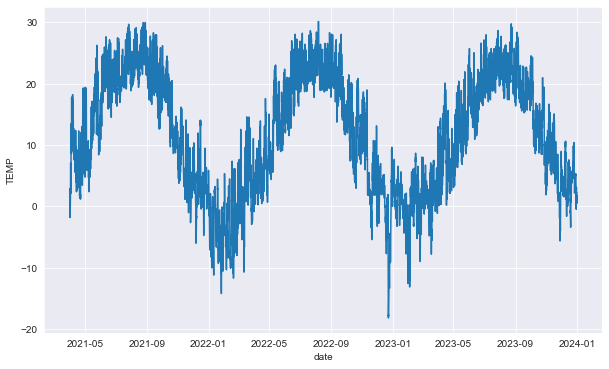

In [10]:
import seaborn as sns
plt.figure(figsize=(10, 6)) 
sns.lineplot(data=df['TEMP'])

In [11]:
df.describe()

,TEMP,PRCP,HMDT,WND_SPD,ATM_PRESS,REF
count,24108.000000,24108.000000,24108.000000,24108.000000,24108.000000,24108.000000
mean,11.551965,0.124557,79.210349,5.579917,99.441695,202215.864111
std,9.487944,0.699789,12.649533,2.681790,0.684361,78.813869
min,-18.220000,0.000000,29.310000,0.100000,95.800000,202103.000000
25%,3.580000,0.000000,70.690000,3.600000,99.020000,202112.000000
50%,11.980000,0.000000,80.810000,5.290000,99.440000,202208.000000
75%,20.112500,0.020000,89.190000,7.170000,99.860000,202304.000000
max,30.150000,38.040000,100.000000,17.840000,101.670000,202312.000000


In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose(timeseries, model, freq=None):
    # Perform decomposition
    results = seasonal_decompose(timeseries, model=model, period=freq)
    
    # Plot the decomposition
    decomposition_plot = results.plot()
    
    # Adjust the figure size
    decomposition_plot.set_figwidth(20)
    decomposition_plot.set_figheight(10)
    
    plt.show()

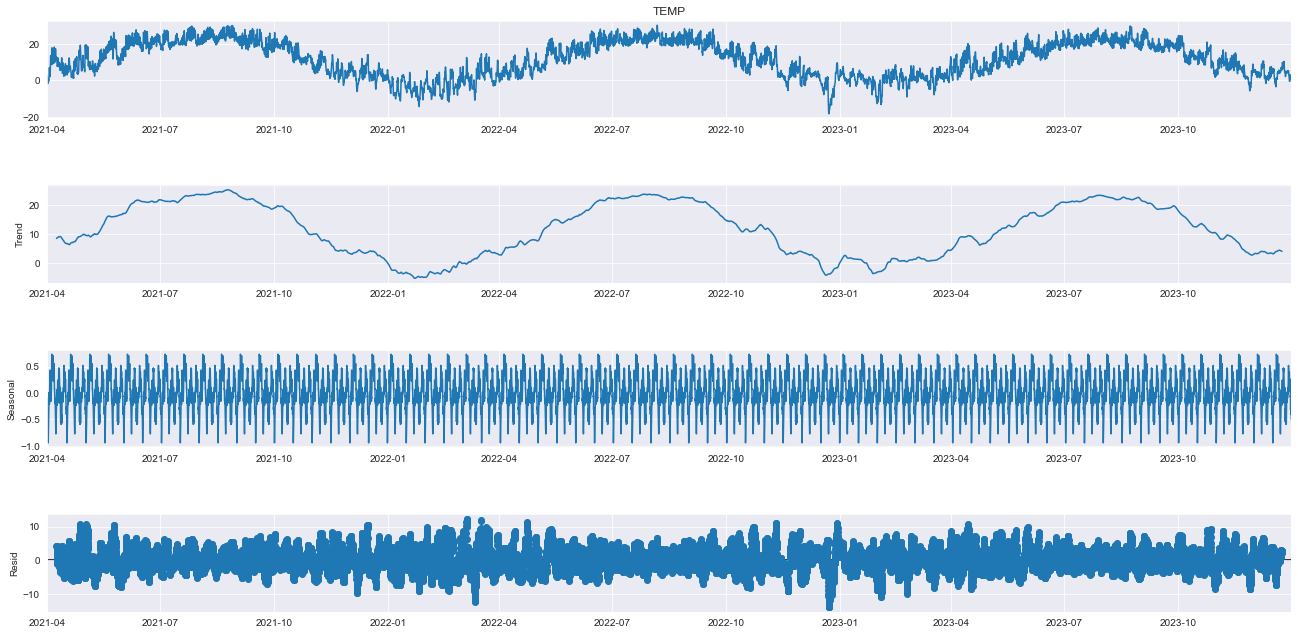

In [13]:
decompose(df['TEMP'], 'additive', 365)

In [19]:
def check_stationary(timeseries):

    result = adfuller(timeseries.values)

    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical value:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print('Stationary')
    else:
        print('Non-stationary')

check_stationary(df['TEMP'])

ADF Statistics: -4.755788
p-value: 0.000066
Critical value:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


In [14]:
df['temp_pred'] = df['TEMP'].shift(1)
df.head()

,TEMP,PRCP,HMDT,WND_SPD,ATM_PRESS,REF,temp_pred
date,,,,,,,
2021-03-31 18:00:00,2.87,0.0,59.62,7.72,100.30,202103,NaN
2021-03-31 19:00:00,2.68,0.0,62.12,7.64,100.38,202103,2.87
2021-03-31 20:00:00,2.34,0.0,66.19,7.88,100.44,202103,2.68
2021-03-31 21:00:00,1.88,0.0,69.12,8.09,100.48,202103,2.34
2021-03-31 22:00:00,1.54,0.0,67.50,8.28,100.52,202103,1.88


In [16]:
df_step1 = df.iloc[1:]

In [17]:
from sklearn.metrics import mean_squared_error
from math import sqrt
errors = sqrt(mean_squared_error(df_step1['TEMP'], df_step1['temp_pred']))
print('Mean squared error: ', errors)

Mean squared error:  0.5835164385202124


In [18]:
import itertools
p = d = q = range(0,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [23]:
import warnings
warnings.filterwarnings("ignore")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = statsmodels.tsa.statespace.SARIMAX(df_step1['temp_pred'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue